Adapted from https://github.com/pastas/pastas/blob/master/doc/examples/recharge_estimation.ipynb

Collenteur, R.A., Bakker, M., Caljé, R., Klop, S.A. and Schaars, F. (2019), Pastas: Open Source Software for the Analysis of Groundwater Time Series. Groundwater, 57: 877-885. https://doi.org/10.1111/gwat.12925

PASTAS utilises a particularly popular subdiscipline of time series analysis: Transfer Function Noise (TFN) Modelling.

TFN attempts to translate one or more input series to an output series using a statistical model. It can be used, for example, to decompose observed head time series into the contributions of the different hydrological stresses that cause the head fluctuations.

In [1]:
# Import the required packages
import pastas as ps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Show the versions of each
ps.show_versions()

Pastas version: 1.10.0
Python version: 3.12.2
NumPy version: 2.2.6
Pandas version: 2.3.0
SciPy version: 1.16.0
Matplotlib version: 3.10.3
Numba version: 0.61.2


A Pastas model can be constructed in seven simple steps:
1. Import Pastas.
2. Read the time series.
3. Create a model.
4. Specify the stresses and the types of response functions.
5. Estimate the model parameters.
6. Visualize output.
7. Analyze the results.

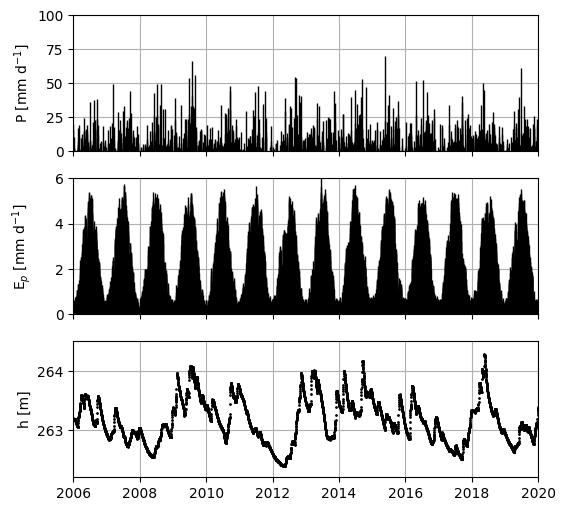

In [2]:
# Load the head, evaporation and precipitation data
head_wagna = (
    pd.read_csv(
        r"C:\Users\Anton\OneDrive\Code\PythonForHydrogeologists\data\MachineLearning\head_wagna.csv", index_col=0, parse_dates=True, skiprows=2)
    .squeeze()
    .loc["2006":]
)
evap_wagna = pd.read_csv(
    r"C:\Users\Anton\OneDrive\Code\PythonForHydrogeologists\data\MachineLearning\evap_wagna.csv", index_col=0, parse_dates=True, skiprows=2
).squeeze()
rain_wagna = pd.read_csv(
    r"C:\Users\Anton\OneDrive\Code\PythonForHydrogeologists\data\MachineLearning\rain_wagna.csv", index_col=0, parse_dates=True, skiprows=2
).squeeze()

### Create a plot of all the input data
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, sharex=True, figsize=(6, 6))

ax1.vlines(rain_wagna.index, [0], rain_wagna.values, color="k", lw=1)
ax1.set_ylabel("P [mm d$^{-1}$]")
ax1.set_ylim(0, 100)
ax2.vlines(evap_wagna.index, [0], evap_wagna.values, color="k", lw=1)
ax2.set_ylabel("E$_p$ [mm d$^{-1}$]\n")
ax2.set_ylim(0, 6)
ax3.plot(head_wagna, marker=".", markersize=2, color="k", linestyle=" ")
ax3.set_ylabel("h [m]")
ax3.set_ylim(262.2, 264.5)
for ax in [ax1, ax2, ax3]:
    ax.grid()

plt.xlim(pd.Timestamp("2006-01-01"), pd.Timestamp("2020-01-01"));

We can additionally view the distribution and some statistics for data exploration.

array([[<Axes: title={'center': 'GWL'}>, <Axes: >, <Axes: >],
       [<Axes: title={'center': 'Evaporation'}>, <Axes: >, <Axes: >],
       [<Axes: title={'center': 'Precipitation'}>,
        <Axes: xlabel='Frequency [%]'>, <Axes: >]], dtype=object)

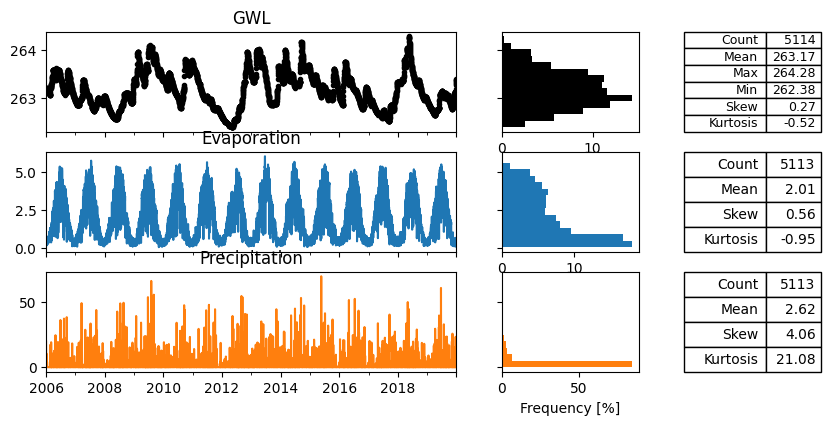

In [3]:
# Plot some statistics related to our data
ps.plots.series(head_wagna, [evap_wagna, rain_wagna], table=True)

The model is given a 'warmup' with the data prior to 2007.

We will add the AutoRegressive Moving Average (ARMA) noise model.

In [4]:
# Model settings
tmin = pd.Timestamp("2007-01-01")  # Needs warmup
tmax = pd.Timestamp("2016-12-31")
tmax_val = pd.Timestamp("2020-01-01")
noise = True
dt = 10
freq = "10D"
h = head_wagna.iloc[0::dt]
h = h.loc[~h.index.duplicated(keep="first")]

# Define the methods to estimate recharge
mls = {
    "Linear": [ps.FourParam(), ps.rch.Linear()],
    "Non-linear": [ps.Exponential(), ps.rch.FlexModel()],
}

# For each method create a recharge model
for name, [rfunc, rch] in mls.items():
    # Create a Pastas model and add the recharge model
    ml2 = ps.Model(h, name=name)
    sm = ps.RechargeModel(rain_wagna, evap_wagna, recharge=rch, rfunc=rfunc, name="rch")
    ml2.add_stressmodel(sm)

    # In case of the non-linear model, change some parameter settings
    if name == "Non-linear":
        ml2.set_parameter("rch_srmax", vary=False)
        ml2.set_parameter("rch_kv", vary=True)
        ml2.set_parameter("rch_lp", vary=False, initial=0.25)
        ml2.set_parameter("constant_d", vary=True, initial=262, pmax=head_wagna.min())

    # Add the ARMA(1,1) noise model and solve the Pastas model
    ml2.add_noisemodel(ps.ArmaNoiseModel())
    solver = ps.LmfitSolve()

    ml2.solve(
        tmin=tmin,
        tmax=tmax,
        solver=solver,
        method="least_squares",
        report="basic",
    )
    mls[name] = ml2

Fit report Linear                 Fit Statistics
nfev    200                    EVP         73.56
nobs    365                    R2           0.74
noise   True                   RMSE         0.20
tmin    2007-01-01 00:00:00    AICc     -1925.53
tmax    2016-12-31 00:00:00    BIC      -1894.73
freq    D                      Obj          1.79
warmup  3650 days 00:00:00     ___              
solver  LmfitSolve             Interp.        No

Parameters (8 optimized)
                optimal     initial  vary
rch_A          0.571673    0.146585  True
rch_n          1.086107    1.000000  True
rch_a        104.170484   10.000000  True
rch_b          0.042876   10.000000  True
rch_f         -0.784224   -1.000000  True
constant_d   262.545007  263.166264  True
noise_alpha   81.222627   10.000000  True
noise_beta     9.835725    1.000000  True

Warnings! (2)
Response tmax for 'rch' > than calibration period.
Response tmax for 'rch' > than warmup period.
Fit report Non-linear             Fit Stati

Using UFloat objects with std_dev==0 may give unexpected results.

After the models are calibrated, the noise time series may be checked for autocorrelation. This is especially important here because in the next step we use the estimated standard errors of the parameters to compute the 95% confidence intervals of the recharge estimates. The plots below show that there is no significant autocorrelation (with
=0.05).

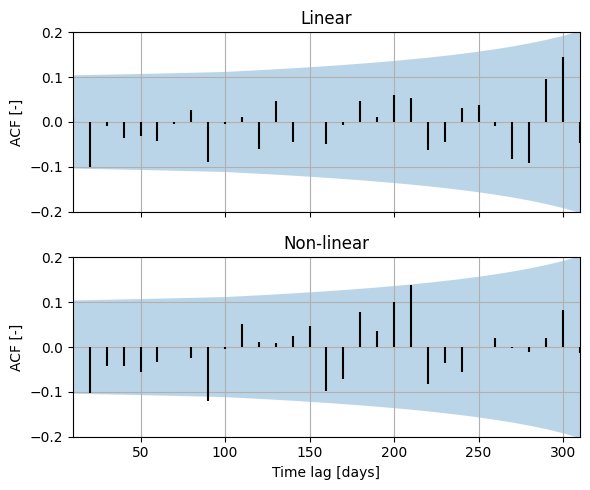

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(6, 5), sharex=True, sharey=True)

for i, ml2 in enumerate(mls.values()):
    noise = (
        ml2.noise().asfreq(freq).fillna(0.0)
    )  # Fill up two nan-values so it is regular
    ps.plots.acf(noise, acf_options=dict(bin_method="regular"), alpha=0.05, ax=axes[i])
    axes[i].set_title(ml2.name)
    axes[i].set_ylim(-0.2, 0.2)
    axes[i].set_ylabel("ACF [-]")
    axes[i].set_xlabel("")

plt.xlim(10)
plt.xlabel("Time lag [days]")
plt.tight_layout()

In [6]:
n = int(1e2)  # number of monte carlo runs, set very low here for ReadTheDocs
alpha = 0.05  # 95% confidence interval
q = [alpha / 2, 1 - alpha / 2]

# Store the Upper and Lower boundaries of the 95% interval
yerru = []
yerrl = []
yerru_A = []
yerrl_A = []

# Recharge data
data_r = pd.DataFrame(
    {
        "Linear": mls["Linear"].get_stress("rch"),
        "Non-linear": mls["Non-linear"].get_stress("rch"),
    }
)

for ml2 in mls.values():
    func = ml2.stressmodels["rch"].get_stress
    params = ml2.solver.get_parameter_sample(n=n, name="rch")
    data = {}

    # Here we run the model n times with different parameter samples
    for i, param in enumerate(params):
        data[i] = func(p=param)

    df = pd.DataFrame.from_dict(data, orient="columns").loc[tmin:tmax_val]

    # store recharge estimates at 10-day intervals
    df = df.resample(freq).sum()
    yerrl.append(df.quantile(q=q, axis=1).transpose().iloc[:, 0])
    yerru.append(df.quantile(q=q, axis=1).transpose().iloc[:, 1])

    # store recharge estimates at one year sums
    df = df.resample("A").sum()
    rch = data_r[ml2.name].resample("A").sum()
    yerrl_A.append(
        df.quantile(q=q, axis=1).transpose().subtract(rch, axis=0).iloc[:, 0].dropna()
    )
    yerru_A.append(
        df.quantile(q=q, axis=1).transpose().subtract(rch, axis=0).iloc[:, 1].dropna()
    )

'A' is deprecated and will be removed in a future version, please use 'YE' instead.'A' is deprecated and will be removed in a future version, please use 'YE' instead.'A' is deprecated and will be removed in a future version, please use 'YE' instead.'A' is deprecated and will be removed in a future version, please use 'YE' instead.

We can now plot the results of our two models and take a look at the different predictions for the validation data.

We also plot the different recharge fluxes for the two different models.

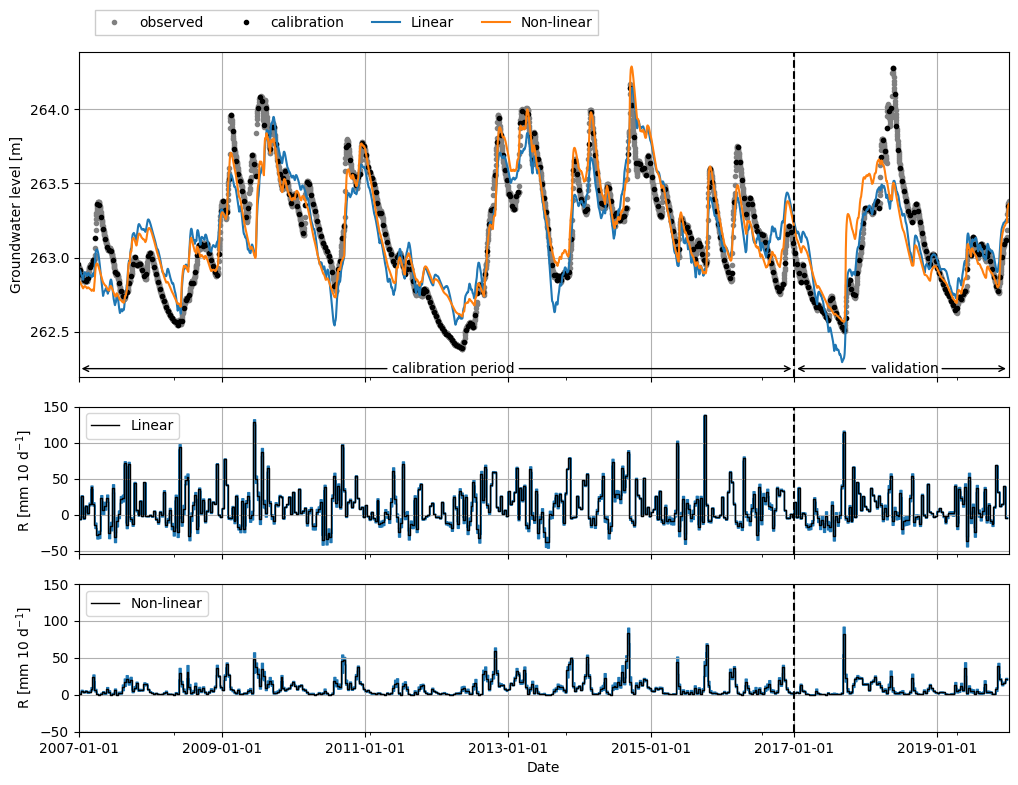

In [7]:
plt.figure(figsize=(12, 10))
ax = plt.subplot2grid((4, 1), (0, 0), rowspan=2)

head_wagna.plot(ax=ax, linestyle=" ", c="gray", marker=".", x_compat=True, label="observed")
ml2.oseries.series.plot(ax=ax, marker=".", c="k", linestyle=" ", label="calibration")

# Create the arrows indicating the calibration and validation period
kwargs = dict(
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    va="center",
    ha="center",
    xycoords="data",
)
ax.annotate("calibration period", xy=("2007-01-01", 262.25), xytext=(270, 0), **kwargs)
ax.annotate("", xy=("2017-01-01", 262.25), xytext=(-200, 0), **kwargs)
ax.annotate("validation", xy=("2017-01-01", 262.25), xytext=(80, 0), **kwargs)
ax.annotate("", xy=("2020-01-01", 262.25), xytext=(-50, 0), **kwargs)

# Plot the recharge fluxes
for i, ml2 in enumerate(mls.values()):
    axn = plt.subplot2grid((4, 1), (i + 2, 0), sharex=ax)
    axn.grid(True, zorder=-10)
    axn.set_axisbelow(True)

    ml2.simulate(tmax=tmax_val).plot(ax=ax, label=ml2.name, x_compat=True)
    rch = ml2.get_stress("rch", tmin=tmin, tmax=tmax_val).resample(freq).sum()

    axn.fill_between(
        yerrl[i].index,
        yerrl[i].values,
        yerru[i].values,
        step="pre",
        edgecolor="C0",
        zorder=0,
        facecolor="C0",
    )
    axn.plot(rch.index, rch.values, c="k", drawstyle="steps", label=ml2.name, lw=1)

    axn.set_yticks([-50, 0, 50, 100, 150])

    axn.set_ylabel("R [mm 10 d$^{-1}$]")
    axn.legend(loc=2, ncol=2)
    axn.axvline(tmax, c="k", linestyle="--")
    axn.set_xticks([])

ax.legend(ncol=5, loc=2, bbox_to_anchor=(0.01, 1.15), framealpha=1, fancybox=False)
ax.axvline(tmax, c="k", linestyle="--")
ax.set_ylabel("Groundwater level [m]")
ax.set_yticks([262.5, 263.0, 263.5, 264.0])
ax.grid()
axn.set_xlim([tmin, tmax_val])
axn.set_xlabel("Date")
axn.set_xticks([pd.to_datetime(str(year)) for year in range(2007, 2021, 2)])

'A' is deprecated and will be removed in a future version, please use 'YE' instead.

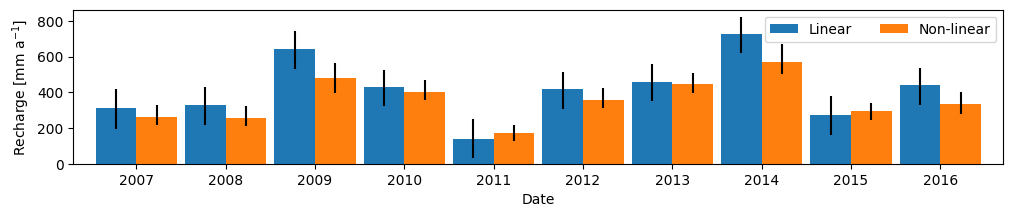

In [8]:
# Plot the mean annual recharge for the linear and non-linear methods
rch = data_r.loc[tmin:"2019"].resample("A").sum()
yerr = [[-l, u] for l, u in zip(yerrl_A, yerru_A)]
ax = rch.plot.bar(figsize=(12, 2), width=0.91, yerr=yerr)
ax.set_xticklabels(labels=rch.index.year, rotation=0, ha="center")
ax.set_ylabel("Recharge [mm a$^{-1}$]")
ax.legend(ncol=3);

In [9]:
# Make a table of the head performance
periods = ["Cal.", "Val."]
mi = pd.MultiIndex.from_product([mls.keys(), periods])
idx = ["mae", "rmse", "nse", "kge_2012"]
index = ["MAE [m]", "RMSE [m]", "NSE [-]", "KGE [-]"]

# Calculate Mean Absolute Error (MAE)
# Calculate Root mean square error (RMSE)
# Calculate Nash–Sutcliffe efficiency (NSE)
# Calculate Kling–Gupta efficiency (KGE)

# Create the metrics dataframe
metrics = pd.DataFrame(index=idx, columns=mi)
for name, ml in mls.items():
    metrics.loc[metrics.index, (name, periods[0])] = (
        ml.stats.summary(stats=metrics.index, tmin=tmin, tmax=tmax)
        .to_numpy()
        .reshape(4)
    )
    metrics.loc[metrics.index, (name, periods[1])] = (
        ml.stats.summary(stats=metrics.index, tmin=tmax, tmax=tmax_val)
        .to_numpy()
        .reshape(4)
    )

# Set the index to the index we have defined
metrics.index = index
# Show the metrics with 2 decimal places
metrics.astype(float).round(2)

kge_2012 is deprecated and will be removed in Pastas version 2.0. This function `kge_2012` will be deprecated in Pastas version 2.0. Please
    use `pastas.stats.kge(modified=True)` to get the same outcome.
kge_2012 is deprecated and will be removed in Pastas version 2.0. This function `kge_2012` will be deprecated in Pastas version 2.0. Please
    use `pastas.stats.kge(modified=True)` to get the same outcome.
kge_2012 is deprecated and will be removed in Pastas version 2.0. This function `kge_2012` will be deprecated in Pastas version 2.0. Please
    use `pastas.stats.kge(modified=True)` to get the same outcome.
kge_2012 is deprecated and will be removed in Pastas version 2.0. This function `kge_2012` will be deprecated in Pastas version 2.0. Please
    use `pastas.stats.kge(modified=True)` to get the same outcome.


Linear       Non-linear      
           Cal.  Val.       Cal.  Val.
MAE [m]    0.17  0.15       0.14  0.18
RMSE [m]   0.20  0.21       0.17  0.23
NSE [-]    0.74  0.69       0.80  0.61
KGE [-]    0.80  0.70       0.87  0.68